#STAR

## 1 Import Modules
In project been used torch, numpy modules.

In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import scipy.sparse as sp
from torch.autograd import Variable

## 2 Loading Models
In this section, project datasets (female, male, neutral in terms of gender) are loaded. The gender to be used in the project is left to the user's choice. The user will enter the gender information as a string.

In [ ]:
 # Star has three gender; male, female,neutral. 
from google.colab import drive
drive.mount('/content/drive')
path_male=os.path.join('/content/drive/My Drive/project/male.npz')
path_female=os.path.join('/content/drive/My Drive/project/female.npz')
path_neutral=os.path.join('/content/drive/My Drive/project/neutral.npz')
gender=str(input("Enter a gender: "))
if gender == 'male':
  path_model = path_male
elif gender == 'female':
  path_model = path_female
else:
  path_model = path_neutral
star = np.load(path_model,allow_pickle=True)  

Mounted at /content/drive
Enter a gender: male


## 3 My Model
Star is 3D human body estimation model. It is a vertex-based LBS model.

###3.1 Kinematic Tree
Quaternion is a set representing joints in the kinematic tree.

In [ ]:
def quaternion(theta):
  '''
  Quaternions are used to represent rotations. Quaternion components are (x,y,z,w) axis. w is the scalar value.
  A Quaternion can be represented as "a + bi + cj + dk".
  With the scalar value next to the 3 vector values, each rotation matrix points to a single angle in the image set.
  Cited: Sola,J.,2017. Quaternion kinematics for the error-state Kalman filter.
  
  '''
  #This code cited by dariopavllo.github 
  #L1 Normalization 
  q_norm=torch.norm(theta+1e-8,p=2,dim=1) 
  angle=torch.unsqueeze(q_norm,-1)
  normalize=torch.div(theta,angle)
  sin=torch.sin(angle*0.5)
  cos=torch.cos(angle*0.5)
  quat=torch.cat([sin*normalize,cos-1],dim=1)
  
  return quat

def quatmat(quat):

  '''
  Converts quaternion to rotation matrix.
  This code cited by gulvarol
  '''
  normalize_q=quat/quat.norm(p=2,dim=1,keepdim=True)
  qw=normalize_q[:,0]
  qx=normalize_q[:,1]
  qy=normalize_q[:,2]
  qz=normalize_q[:,3]
  xy=2*qx*qy
  xz=2*qx*qz
  yz=2*qy*qz
  wx=2*qw*qx
  wy=2*qw*qy
  wz=2*qz*qy
  x2=qx.pow(2)
  y2=qy.pow(2)
  z2=qz.pow(2)
  w2=qw.pow(2)
  rotMat=torch.stack([w2+x2-y2-z2,xy-wz,wy+xz,wz+xy,w2-x2+y2-z2,yz-wx,xz-wy,wx+yz,w2-x2-y2+z2],dim=1).view(quat.size(0),3,3)
  
  return rotMat

### 3.2 Rodrigues
Rodrigues represent joint angles.

In [ ]:
def Rodrigues(theta):
  '''
  Rodrigues rotation formula that turns axis-angle vector into rotation 
  matrix in a batch-ed manner.
  Rotation matrix of shape [batch_size, 24, 3, 3].
  theta: batch_size x number of joints x 3
  '''
  #L1 Normalization
  q_norm=torch.norm(theta+1e-8,p=2,dim=1)
  angle=torch.unsqueeze(q_norm,-1)
  normalize=torch.div(theta,angle)
  sin=torch.sin(angle*0.5)
  cos=torch.cos(angle*0.5)
  quat=torch.cat([cos,sin*normalize],dim=1)
  
  return quatmat(quat)

# This code cited by CalciferZh
def with_zeros(X):
  '''
    Append a [0, 0, 0, 1] vector to a batch of [3, 4] matrices.     
    x: Tensor to be appended of shape [batch_size, 3, 4]
    Tensor after appending of shape [batch_size, 4, 4]
  '''
  batch_size=X.shape[0]
  row=torch.cuda.FloatTensor(([0.0,0.0,0.0,1.0]))
  row.requires_grad=False
  padded=torch.cat([X,row.view(1,1,4).repeat(batch_size,1,1)],1)
  return padded

### 3.3 Model
Libraries that define the human body in the loaded dataset are defined in this section. Then, the functions (blend and pose shape) in the article are shown in the forward() section to create the model.

In [ ]:
class MyStar(nn.Module):
  def __init__(self,gender='male',num_beta=10):
    super(MyStar,self).__init__()

    '''
    posedirs, v_template, J_regressor, weights are model dictionary.
    num_beta: Parameter for model shape. A vector of shape [10].
    v_template: Template mesh.
    shapedirs: The tensor of PCA shape displacements.
    posedirs: The pose coefficients.
    J_regressor: The regressor array that is used to calculate the joints from the position of the vertices.
    parents: The array that describes the kinematic tree for the model
    weights: The linear blend skinning weights that represent how much the rotation matrix of each part affects each vertex
  
    '''
    self.num_beta=num_beta
    J_regressor = star['J_regressor']
    # Model sparse joints regressor, regresses joints location from a mesh
    self.register_buffer('J_regressor', torch.cuda.FloatTensor(J_regressor))
    # Skinning weights
    self.register_buffer('weights', torch.cuda.FloatTensor(star['weights']))
    # Pose corrective blend shapes
    self.register_buffer('posedirs', torch.cuda.FloatTensor(star['posedirs'].reshape((-1,93))))
    # Mean Shape
    self.register_buffer('v_template', torch.cuda.FloatTensor(star['v_template']))
    # Shape corrective blend shapes
    self.register_buffer('shapedirs', torch.cuda.FloatTensor(np.array(star['shapedirs'][:,:,:num_beta])))
    # Mesh traingles
    self.register_buffer('faces', torch.from_numpy(star['f'].astype(np.int64)))
    #self.face = star['f']
    # Kinematic tree 
    self.register_buffer('kintree_table', torch.from_numpy(star['kintree_table'].astype(np.int64)))
    
    id_to_col = {self.kintree_table[1, i].item(): i for i in range(self.kintree_table.shape[1])}
    self.register_buffer('parent', torch.LongTensor(
            [id_to_col[self.kintree_table[0, j].item()] for j in range(1, self.kintree_table.shape[1])]))
    
    self.verts=None
    self.J = None
    self.R = None
    self.G = None

  def forward(self, pose, betas , trans):

    '''
    pose: Also known as 'theta', a [24,3] matrix.
          Represented in a axis-angle format.
          Batch_size x 72 (3, each joint)
    trans: Global translation of shape [3].
    betas: Batch_size x 3
    '''
    device = pose.device
    batch_size=pose.shape[0]
    v_template=self.v_template[None,:]
    shapedirs=self.shapedirs.view(-1,self.num_beta)[None,:].expand(batch_size,-1,-1)
    beta=betas[:,:,None]
    # Shape Blend Shape
    blend_shape=torch.matmul(shapedirs,beta)
    # Corrective blend shape
    v_shaped=v_template+blend_shape.view(-1,6890,3) #Vshaped=T+Bs   
    # Pose Blend Shape
    pose_quat=quaternion(pose.view(-1,3)).view(batch_size,-1)
    pose_feat=torch.cat((pose_quat[:,4:],beta[:,1]),1) 
    posedirs=self.posedirs[None, :].expand(batch_size, -1, -1)
    pose_blend=torch.matmul(posedirs,pose_feat[:,:,None]).view(-1,6890,3)
    # Corrective pose shape
    v_posed=v_shaped+pose_blend 
    # Joint Location
    self.J = torch.einsum('bik,ji->bjk', [v_shaped, self.J_regressor])
    # Rotation matrix for each joint
    self.R=Rodrigues(pose.view(-1,3)).view(batch_size,24,3,3) #Pose Angle (24*3)
    R=self.R.view(batch_size,24,3,3)
    # World transformation of each joint
    J1=self.J.clone()
    J1[:,1:,:]=self.J[:,1:,:]-self.J[:,self.parent,:]
    G1=torch.cat([R,J1[:,:,:,None]],dim=-1)
    row_pad=torch.FloatTensor([0,0,0,1]).to(device).view(1,1,1,4).expand(batch_size,24,-1,-1)
    G1=torch.cat([G1,row_pad],dim=2)
    self.G=[G1[:,0].clone()]
    for i in range(1,24):
      self.G.append(torch.matmul(self.G[self.parent[i-1]],G1[:,i,:,:]))
    G=torch.stack(self.G,dim=1)
    rest=torch.cat([self.J,torch.zeros(batch_size,24,1).to(device)],dim=2).view(batch_size,24,4,1)
    zeros=torch.zeros(batch_size,24,4,3).to(device)
    rest=torch.cat([zeros,rest],dim=-1)
    rest=torch.matmul(G,rest)
    G=G-rest
    # Blend Skinning
    T=torch.matmul(self.weights,G.permute(1,0,2,3).contiguous().view(24,-1)).view(6890,batch_size,4,4).transpose(0,1)
    rest_shape_h=torch.cat([v_posed,torch.ones_like(v_posed)[:,:,[0]]],dim=-1)
    v=torch.matmul(T,rest_shape_h[:,:,:,None])[:,:,:3,0]
    v=v+trans[:,None,:]
    v.faces=self.faces
    v.v_posed=v_posed
    v.v_shaped=v_shaped
    # Batch of rigid transformations to the joint
    root_trans=with_zeros(torch.cat((R[:,0],self.J[:,0][:,:,None]),2))
    result=[root_trans]
    for i in range(0,self.parent.shape[0]):
      trans_i=with_zeros(torch.cat((R[:,i+1],self.J[:,i+1][:,:,None]-self.J[:,self.parent[i]][:,:,None]),2))
      current_rest=torch.matmul(result[self.parent[i]],trans_i)
      result.append(current_rest)
    result=torch.stack(result,dim=1)
    joint=result[:,:,:3,3]
    v.J_transformed=joint+trans[:,None,:]
    
    return v

### Test GPU

In [ ]:
from time import time

def test_gpu():
    
  device = torch.device('cuda')
  batch_size=1
  np.random.seed(9608)
  model = MyStar()
  time_list = []
  for i in range(10):
      poses = torch.cuda.FloatTensor(np.zeros((batch_size,72)))
      poses = Variable(poses,requires_grad=True)
      betas = torch.cuda.FloatTensor(np.zeros((batch_size,10)))
      betas = Variable(betas,requires_grad=True)
      trans = torch.cuda.FloatTensor(np.zeros((batch_size,3)))
      trans = Variable(trans,requires_grad=True)      
      s = time()
      result = model(poses, betas, trans)
      cost_time = time() - s
      print(cost_time)
      time_list.append(cost_time)
  print('mean cost:', np.mean(time_list[1:]))
  
if __name__ == '__main__':
  test_gpu()

0.18075323104858398
0.00896763801574707
0.007368803024291992
0.007143974304199219
0.00713801383972168
0.006975889205932617
0.007117509841918945
0.007091999053955078
0.007129669189453125
0.006811618804931641
mean cost: 0.007305012808905708


## 4 Mesh

In [ ]:
# This code cited by vchoutas on github
def row(A):
  return A.reshape((1,-1))

def col(A):
  return A.reshape((-1,1))

def get_vert_connectivity(mesh_v,mesh_f):
    '''
    Returns a sparse matrix (of size #verts x #verts) where each nonzero
    element indicates a neighborhood relation. For example, if there is a
    nonzero element in position (15,12), that means vertex 15 is connected
    by an edge to vertex 12.

    '''
    vpv=sp.csc_matrix((len(mesh_v),len(mesh_v)))
    # for each column in the faces...
    for i in range(3):
        IS = mesh_f[:, i]
        JS = mesh_f[:, (i + 1) % 3]
        data = np.ones(len(IS))
        ij = np.vstack((row(IS.flatten()), row(JS.flatten())))
        mtx = sp.csc_matrix((data, ij), shape=vpv.shape)
        vpv = vpv + mtx + mtx.T
    return vpv

def get_vertices_per_edge(mesh_v, mesh_f):

    '''
    Returns an Ex2 array of adjacencies between vertices, where
    each element in the array is a vertex index. Each edge is included
    only once. If output of get_faces_per_edge is provided, this is used to
    avoid call to get_vert_connectivity()
    
    '''
    vc = sp.coo_matrix(get_vert_connectivity(mesh_v, mesh_f))
    result = np.hstack((col(vc.row), col(vc.col)))
    result = result[result[:, 0] < result[:, 1]]  # for uniqueness
    return result

## 5 Loss
I calculated loss functions with L1 and L2 norm.

In [ ]:
# Edge Loss 
def edge_loss(input,target):
    vpe = get_vert_connectivity(6890,input.faces)
    edges_red = lambda x: x[:,vpe[:,0],:] - x[:,vpe[:,1],:]
    edge_obj = edges_red(input) - edges_red(target)
    return edge_obj

# Vertices Loss 
def vert_loss(input,target):
  vert_obj=torch.sum((input,target).pow(2))
  return vert_obj

# Mean Absolute Error
def v2v_loss(input,target):
  mae=torch.mean(torch.sqrt(torch.sum((input-target).pow(2),dim=-1)))
  return mae

## 6 Smpl --> Star
In this section, SMPL vertices are converted to STAR parameters in order to obtain SMPL and STAR output according to two different datasets in the article.

In [ ]:
def smpl_2_star(target,edge_iter,vert_iter,num_beta):
    
    smpl = torch.cuda.FloatTensor(target)
    batch_size = smpl.shape[0]
    global_pose = torch.cuda.FloatTensor(np.zeros((batch_size, 3)))
    global_pose = Variable(global_pose, requires_grad=True)
    joint_pose = torch.cuda.FloatTensor(np.zeros((batch_size, 72 - 3)))
    joint_pose = Variable(joint_pose, requires_grad=True)
    betas = torch.cuda.FloatTensor(np.zeros((batch_size, num_beta)))
    betas = Variable(betas, requires_grad=True)
    trans = torch.cuda.FloatTensor(np.zeros((batch_size, 3)))
    trans = Variable(trans, requires_grad=True)
    poses=torch.cat((global_pose,joint_pose),1)
    model=MyStar(num_beta=num_beta)
    input=model(poses,betas,trans)
    tr_poses = poses.detach().cpu().numpy()
    tr_betas = betas.detach().cpu().numpy()
    tr_trans = trans.detach().cpu().numpy()
    tr_verts = input.detach().cpu().numpy()
    
    return tr_poses , tr_betas , tr_trans , tr_verts

## 7 Trainer

In [ ]:
def train(global_pose,joint_pose,poses,betas,trans,edge_iter,vert_iter,optimizer_edge,optimizer_vert,target):
  for i in range(edge_iter):
    input=model(poses,betas,trans)
    loss=torch.sum(edge_loss(input,target)**2)
    optimizer_edge.zero_grad()
    loss.backward()
    optimizer_edge.step()
    return loss
  
  for i in range(vert_iter):
    input=model(poses,betas,trans)
    loss=torch.sum(vert_loss(input,target)**2)
    optimizer_vert.zero_grad()
    loss.backward()
    optimizer_vert.step()
    return loss

In [ ]:
path_smpl = os.path.join('/content/drive/My Drive/project/smpl_meshes.npy')
edge_iter=100
vert_iter=1500
learning_rate=0.01
num_beta=10
params = {'edge_iter':edge_iter ,
          'vert_iter':vert_iter,
          'num_beta':num_beta}

smpl = np.load(path_smpl)
tr_poses , tr_betas , tr_trans , tr_verts= smpl_2_star(smpl,**params)
results = {'poses':tr_poses,'betas':tr_betas,'trans':tr_trans,'verts':tr_verts}

In [ ]:
# Let's save the converted SMPL parameters.
path_save= ('save.npy')
np.save(path_save,results)

## 8 Visualize Model
Model will visualized.

In [ ]:
# This code cited by gulvarol on github.
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def display_model(model_info,model_faces=None,
                  plot_joints=False,kintree_table=None,
                  ax=None,batch_idx=0,show=True,savepath=None):
  if ax is None:
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    verts,joints=model_info['vertices'][batch_idx], model_info['joints'][batch_idx]
    if model_faces is None:
      ax.scatter(verts[:,0],verts[:,1],verts[:,2],s=0.2,c='k')
    else:
      mesh=Poly3DCollection(verts[model_faces],alpha=0.3)
      face_color = (128 / 128, 128 / 128, 128 / 128)
      edge_color = (48 / 128, 48/ 128, 48/ 128)
      mesh.set_edgecolor(edge_color)
      mesh.set_facecolor(face_color)
      ax.add_collection3d(mesh)
    
    if plot_joints:
        draw_skeleton(joints, kintree_table=kintree_table, ax=ax)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-0.7,0.7)
    ax.set_ylim(-0.7,0.7)
    ax.set_zlim(-0.7,0.7)
    ax.view_init(azim=-90, elev=100)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    if savepath:
        print('Saving figure at {}.'.format(savepath))
        plt.savefig(savepath, bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    return ax
    
def draw_skeleton(joints3D, kintree_table, ax=None):
  if ax is None:
        fig = plt.figure(frameon=False)
        ax = fig.add_subplot(111, projection='3d')
  else:
        ax = ax
  # For each 24 joint
  for i in range(1, 24):
      j1 = kintree_table[0][i]
      j2 = kintree_table[1][i]
      ax.plot([joints3D[j1, 0], joints3D[j2, 0]],
              [joints3D[j1, 1], joints3D[j2, 1]],
              [joints3D[j1, 2], joints3D[j2, 2]]) 
    
  return ax

Saving figure at image.png.


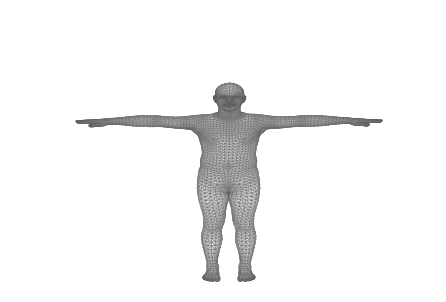

In [ ]:
batch_size=1
num_beta=10
m = MyStar(gender='male',num_beta=num_beta)
betas=torch.cuda.FloatTensor(np.zeros((batch_size,10)))
poses = torch.cuda.FloatTensor(np.zeros((batch_size,72)))
trans = torch.cuda.FloatTensor(np.zeros((batch_size,3)))
mystar = m.forward(poses,betas,trans)
shaped = mystar.v_shaped[-1, :, :]
display_model(
        {'vertices': mystar.cpu().detach(),
         'joints': mystar.cpu().detach()},
        model_faces=m.faces,
        plot_joints=True,
        kintree_table=m.kintree_table,
        savepath='image.png',
        show=True)